<img src="https://storage.googleapis.com/kaggle-datasets-images/130081/310927/007f156e945286c81911147dd952ad22/dataset-cover.jpg?t=2019-03-02-09-45-36" width="100%">
<center><h1>AIDA Final Project</h1></center>
<center><p>Image Scene Classification</p></center>

We will use [this](https://www.kaggle.com/puneet6060/intel-image-classification) Kaggle dataset which contains 25k images of the 6 categories. Our goal is to develop an algorithm which can distinguish the different image categories. I this approach I will use Tensorflow Keras together with pretained models provided by the framework.

In [9]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


In [10]:
tf.__version__

'2.3.0'

In [11]:
!nvidia-smi

Thu Dec  3 18:53:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download & Prepare Dataset

In [15]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Download the artist dataset using the Kaggle API. In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine. Upload `kaggle.json` into Google Colab Files

In [16]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
os.chmod("/content", 600)
os.chmod("/content/kaggle.json", 600)

or set username and API-Key as enviroment variables

```
os.environ['KAGGLE_USERNAME'] = 'paulbauriegel'
os.environ['KAGGLE_KEY'] = '...'
```

Authenticate and Download Dataset from Kaggle

In [17]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [18]:
api.dataset_download_files('puneet6060/intel-image-classification', unzip=True)

In [12]:
images_dir = '/content/seg_train/seg_train'
class_names = os.listdir(images_dir)
n_classes = len(class_names)

### Create Image Classification Model

Import some Keras functionality

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [14]:
IMG_SIZE = 150

#### Transfer learning and fine-tuning - different approaches

With Keras we can use the weights from a pre-trained model. These weights have been trained on a large-scale image-classification task called *imagenet*. We can proceed by different approaches:

1. **Feature-Extraction**: Use the pretrained model for Feature-Extraction network and set some classification layers ontop. Use `include_top=False` and freeze the layers of the base model

2. **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model.

    2.1. V1: Un-freeze the top layers of the model - approach used in the [Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning) and by the [DeepArtist](https://www.kaggle.com/supratimhaldar/deepartist-identify-artist-from-art) implementation. First we train the hole model including the new classification layers

    2.2. V2: Opposite Approach - train the hole model for 10 epochs and then train the top 50 layers for 50 epochs

    2.3. V3: Train all layers - for 60 epochs

In [15]:
# Train the model - all layers
def trainfull_ResNet50(train_gen, val_gen, class_weights=None, 
                       full_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  model = ResNet50(include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                        classes=n_classes, weights=None, )
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)

  return model, history

In [16]:
# Train the model - all layers
def fextraction_ResNet50(train_gen, val_gen, class_weights=None, 
                   full_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

  for layer in base_model.layers:
      layer.trainable = False

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)

  return model, history

In [17]:
# Train the model - all layers
def finetune_ResNet50_v1(train_gen, val_gen, class_weights=None, 
                   full_epochs = 10, fine_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

  for layer in base_model.layers:
      layer.trainable = True

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history1 = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)
  
  # Freeze core ResNet layers and train again 
  for layer in model.layers:
      layer.trainable = False

  for layer in model.layers[:50]:
      layer.trainable = True

  history2 = model.fit(train_gen,  
                       #steps_per_epoch=STEP_SIZE_TRAIN,
                       validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                       epochs=fine_epochs,
                       shuffle=True,
                       verbose=1,
                       callbacks=[reduce_lr, early_stop],
                       class_weight=class_weights )
  history = {}
  history['loss'] = history1.history['loss'] + history2.history['loss']
  history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
  history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
  history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
  history['lr'] = history1.history['lr'] + history2.history['lr']
  return model, history

In [18]:
# Train the model - all layers
def finetune_ResNet50_v2(train_gen, val_gen, class_weights=None, 
                   full_epochs = 10, fine_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

  for layer in base_model.layers:
      layer.trainable = True

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history1 = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)
  
  # Freeze core ResNet layers and train again 
  for layer in model.layers:
      layer.trainable = False

  for layer in model.layers[-50:]:
      layer.trainable = True

  history2 = model.fit(train_gen,  #steps_per_epoch=STEP_SIZE_TRAIN,
                       validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                       epochs=fine_epochs,
                       shuffle=True,
                       verbose=1,
                       callbacks=[reduce_lr, early_stop],
                       class_weight=class_weights )
  history = {}
  history['loss'] = history1.history['loss'] + history2.history['loss']
  history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
  history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
  history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
  history['lr'] = history1.history['lr'] + history2.history['lr']
  return model, history

In [19]:
# Train the model - all layers
def finetune_ResNet50_v3(train_gen, val_gen, class_weights=None, 
                   full_epochs = 100):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

  for layer in base_model.layers:
      layer.trainable = True

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)
  return model, history

#### Online Data Augumentation

In [20]:
preprocess_gen = ImageDataGenerator(rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

In [21]:
batch_size = 256#32

In [22]:
# Get path of files
l = []
import itertools
for class_name in os.listdir(images_dir):
  l+= [os.path.join(class_name, x) for x in os.listdir(os.path.join(images_dir, class_name))]
l_y = [x.split('/')[0] for x in l]

#### Calculate Class weights

In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', class_names, l_y)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9729617304492513,
 1: 0.9311305732484076,
 2: 1.0299427564949362,
 3: 1.0285839929639402,
 4: 1.067549064354176,
 5: 0.9819479429051218}

#### Visualisation

In [24]:
# Plot the training graph
from tensorflow.keras.callbacks import History

def plot_history(history):
    if isinstance(history, History):
      history = history.history
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc)+1)

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r--', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r--', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b-', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()

### Model Training

#### Data Loading

In [25]:
train_generator_l = preprocess_gen.flow_from_directory(
    directory='/content/seg_train/seg_train',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=True,
    classes=class_names)

valid_generator_l = preprocess_gen.flow_from_directory(
    directory='/content/seg_test/seg_test',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=True,
    classes=class_names)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


#### Visualisation

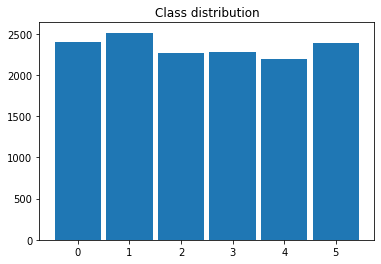

In [26]:
plt.hist(train_generator_l.classes, 
         bins=np.array([0, 1, 2, 3, 4, 5, 6])-0.5, rwidth=0.9)
plt.title('Class distribution');

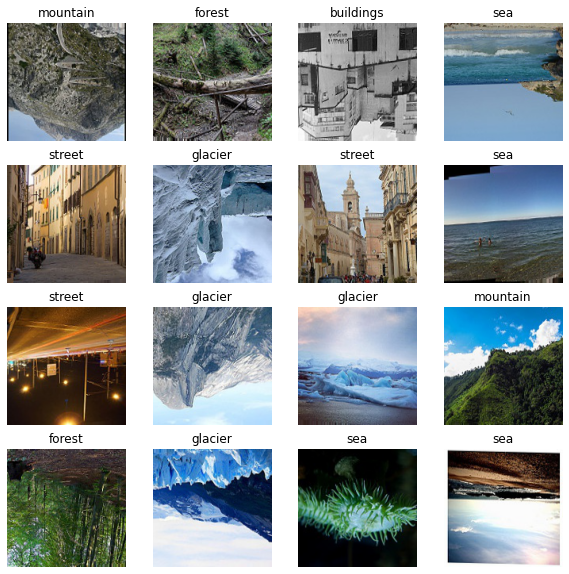

In [27]:
plt.figure(figsize=(10, 10))
for image, label in train_generator_l:
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(image[i])
    ax.set_title(class_names[np.argmax(label[i])])
    ax.axis("off")
  break

#### Training

##### Feature Extraction train only dense layers

In [ ]:
model_fe_RN50, history_fe_RN50 = fextraction_ResNet50(train_generator_l, 
                                                      valid_generator_l, 
                                                      class_weights, 
                                                      full_epochs=250)

In [ ]:
(round(np.mean(history_fe_RN50.history['val_accuracy'][100:]), 4), 
 round(np.std(history_fe_RN50.history['val_accuracy'][100:]), 4))

In [ ]:
plot_history(history_fe_RN50)

In [ ]:
model_fe_RN50.save('model_fe_RN50.h5')

##### FineTuning train only first layers

In [ ]:
model_ftv1_RN50, history_ftv1_RN50 = finetune_ResNet50_v1(train_generator_l, 
                                                          valid_generator_l, 
                                                          class_weights,
                                                          fine_epochs=150)

Epoch 1/10
110/110 [==============================] - 160s 1s/step - loss: 0.6048 - accuracy: 0.8789 - val_loss: 1.9756 - val_accuracy: 0.0980
Epoch 2/10
110/110 [==============================] - 157s 1s/step - loss: 0.4230 - accuracy: 0.9382 - val_loss: 1.8839 - val_accuracy: 0.1413
Epoch 3/10
110/110 [==============================] - 157s 1s/step - loss: 0.3637 - accuracy: 0.9477 - val_loss: 1.8460 - val_accuracy: 0.2097
Epoch 4/10
110/110 [==============================] - 158s 1s/step - loss: 0.3136 - accuracy: 0.9587 - val_loss: 1.5459 - val_accuracy: 0.3943
Epoch 5/10
110/110 [==============================] - 156s 1s/step - loss: 0.2729 - accuracy: 0.9652 - val_loss: 1.1571 - val_accuracy: 0.5947
Epoch 6/10
110/110 [==============================] - 157s 1s/step - loss: 0.2328 - accuracy: 0.9733 - val_loss: 1.0168 - val_accuracy: 0.6587
Epoch 7/10
110/110 [==============================] - 158s 1s/step - loss: 0.2033 - accuracy: 0.9781 - val_loss: 0.6675 - val_accuracy: 0.8053

In [ ]:
model_ftv1_RN50.evaluate(valid_generator_l)

24/24 [==============================] - 26s 1s/step - loss: 0.2465 - accuracy: 0.9350


[0.24653196334838867, 0.9350000023841858]

In [ ]:
model_ftv1_RN50.save('model_ftv1_RN50.h5')

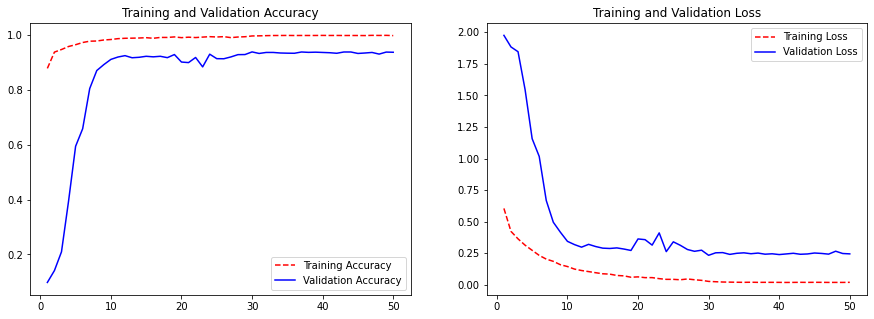

In [ ]:
plot_history(history_ftv1_RN50)

In [ ]:
(round(np.mean(history_ftv1_RN50['val_accuracy'][-20:]), 4), 
 round(np.std(history_ftv1_RN50['val_accuracy'][-20:]), 4))

(0.9361, 0.0021)

##### FineTuning train only last layers

In [ ]:
model_ftv2_RN50, history_ftv2_RN50 = finetune_ResNet50_v2(train_generator_l, 
                                                          valid_generator_l, 
                                                          class_weights,
                                                          fine_epochs=150)

Epoch 1/10
110/110 [==============================] - 160s 1s/step - loss: 0.7653 - accuracy: 0.8345 - val_loss: 1.8570 - val_accuracy: 0.1697
Epoch 2/10
110/110 [==============================] - 157s 1s/step - loss: 0.5741 - accuracy: 0.9305 - val_loss: 1.9579 - val_accuracy: 0.1587
Epoch 3/10
110/110 [==============================] - 157s 1s/step - loss: 0.4960 - accuracy: 0.9448 - val_loss: 1.9806 - val_accuracy: 0.1550
Epoch 4/10
110/110 [==============================] - 157s 1s/step - loss: 0.4369 - accuracy: 0.9562 - val_loss: 1.6453 - val_accuracy: 0.3987
Epoch 5/10
110/110 [==============================] - 157s 1s/step - loss: 0.3799 - accuracy: 0.9644 - val_loss: 1.4012 - val_accuracy: 0.5330
Epoch 6/10
110/110 [==============================] - 157s 1s/step - loss: 0.3390 - accuracy: 0.9694 - val_loss: 0.9397 - val_accuracy: 0.7383
Epoch 7/10
110/110 [==============================] - 157s 1s/step - loss: 0.3007 - accuracy: 0.9737 - val_loss: 0.7564 - val_accuracy: 0.8087

In [ ]:
model_ftv2_RN50.evaluate(valid_generator_l)

24/24 [==============================] - 27s 1s/step - loss: 0.2319 - accuracy: 0.9387


[0.23193910717964172, 0.9386666417121887]

In [ ]:
model_ftv2_RN50.save('model_ftv2_RN50.h5')

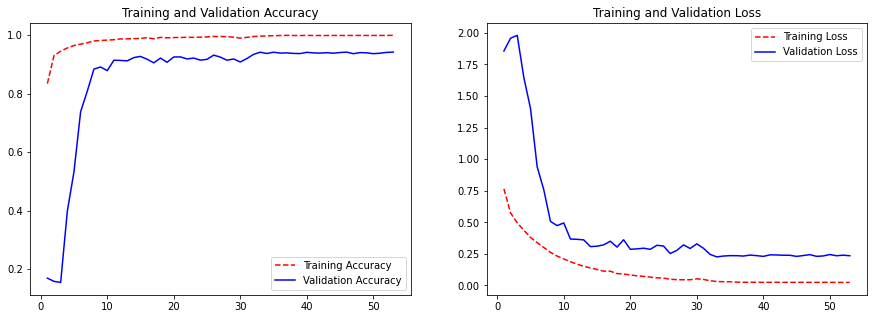

In [ ]:
plot_history(history_ftv2_RN50)

In [ ]:
(round(np.mean(history_ftv1_RN50['val_accuracy'][-20:]), 4), 
 round(np.std(history_ftv1_RN50['val_accuracy'][-20:]), 4))

(0.9361, 0.0021)

##### FineTuning train all layers

In [14]:
model_ftv3_RN50, history_ftv3_RN50 = finetune_ResNet50_v3(train_generator_l, 
                                                          valid_generator_l, 
                                                          class_weights,
                                                          full_epochs=150)

NameError: ignored

In [ ]:
model_ftv3_RN50.evaluate(valid_generator_l)

24/24 [==============================] - 27s 1s/step - loss: 0.2411 - accuracy: 0.9387


[0.2410845309495926, 0.9386666417121887]

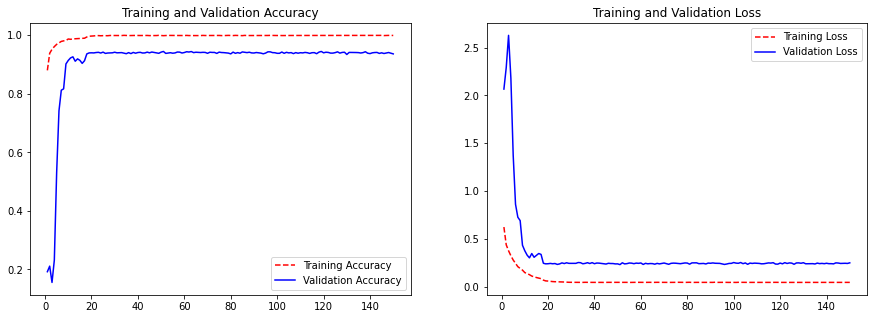

In [ ]:
plot_history(history_ftv3_RN50)

In [ ]:
model_ftv3_RN50.save('model_ftv3_RN50.h5')

##### Train from Scratch

In [28]:
model_full_RN50, history_full_RN50 = trainfull_ResNet50(train_generator_l, 
                                                        valid_generator_l, 
                                                        class_weights,
                                                        full_epochs=150)

Epoch 1/150
55/55 [==============================] - 100s 2s/step - loss: 1.4057 - accuracy: 0.4526 - val_loss: 2.1832 - val_accuracy: 0.1750
Epoch 2/150
55/55 [==============================] - 96s 2s/step - loss: 1.0257 - accuracy: 0.6037 - val_loss: 2.7840 - val_accuracy: 0.1750
Epoch 3/150
55/55 [==============================] - 96s 2s/step - loss: 0.9183 - accuracy: 0.6449 - val_loss: 3.1188 - val_accuracy: 0.1757
Epoch 4/150
55/55 [==============================] - 95s 2s/step - loss: 0.8408 - accuracy: 0.6786 - val_loss: 2.8732 - val_accuracy: 0.2133
Epoch 5/150
55/55 [==============================] - 94s 2s/step - loss: 0.7894 - accuracy: 0.7044 - val_loss: 3.3726 - val_accuracy: 0.2923
Epoch 6/150
55/55 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.7231
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
55/55 [==============================] - 94s 2s/step - loss: 0.7439 - accuracy: 0.7231 - val_loss: 3.2127 - val_accurac

In [29]:
F.evaluate(valid_generator_l)

12/12 [==============================] - 15s 1s/step - loss: 0.5789 - accuracy: 0.7880


[0.578904926776886, 0.7879999876022339]

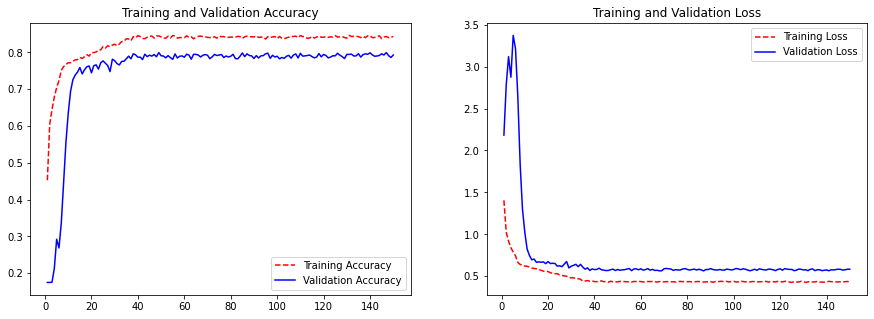

In [30]:
plot_history(history_full_RN50)

In [31]:
model_full_RN50.save('/content/drive/MyDrive/model_full_RN50.h5')

## Summary

to lazy to write one - top validation accuracy is 94% average is around 93%

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/model_ftv2_RN50.h5'

In [ ]:
model = load_model(MODEL_PATH)

In [ ]:
class_names

['glacier', 'street', 'sea', 'mountain', 'forest', 'buildings']

5
Predicted class = buildings
Prediction probability = 98.17387461662292 %


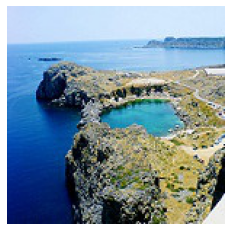

In [ ]:
import imageio
import cv2

web_image = imageio.imread('/content/seg_test/seg_test/sea/20112.jpg')
web_image = cv2.resize(web_image, dsize=(224, 224)).astype('float')
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)

prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)
print(prediction_idx)

print("Predicted class =", class_names[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread('/content/seg_test/seg_test/sea/20112.jpg'))
plt.axis('off')
plt.show()

In [ ]:
class_names = ['glacier','street', 'buildings', 'forest', 'mountain', 'sea']

In [ ]:
web_image.shape

(1, 150, 150, 3)

In [ ]:
prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

In [ ]:
model.p